<a href="https://colab.research.google.com/github/Geebigib/Data-Science-Project/blob/main/COUTA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pip install torch==1.8.1+cpu torchvision==0.9.1+cpu torchaudio===0.8.1 -f https://download.pytorch.org/whl/torch_stable.html
# !pip install -r requirements.txt

In [4]:
!pip install GPUtil==1.4.0 torch==1.10.1 PyYAML~=5.1.2 tqdm==4.62.3 joblib~=1.0.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |██████████████████████████████▎ | 834.1 MB 1.2 MB/s eta 0:00:39tcmalloc: large alloc 1147494400 bytes == 0x38b8c000 @  0x7f55813de615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |████████████████████████████████| 881.9 MB 14 kB/s 
     |████████████████████████████████| 265 kB 47.8 MB/s 
     |████████████████████████████████| 76 kB 5.4 MB/s 
     |████████████████████████████████| 303 kB 61.4 MB/s 
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=167c5ad28451db12c5d2aacf9fdf71b82f519b809c538368b49121ec53cb183c
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
  Cre

In [5]:
!pip install pyod

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 134 kB 7.0 MB/s 
  Created wheel for pyod: filename=pyod-1.0.4-py3-none-any.whl size=165073 sha256=6cb501d272169b65706bbdddf56fa340945ef92b6cebbf831bf1eeb7373656dd
  Stored in directory: /root/.cache/pip/wheels/3d/48/a8/87d61660791c7e6b0f5c3068da7fb17ade7fdc041e864fe053
Successfully built pyod


In [6]:
# !unzip /content/drive/MyDrive/SWaT_Dataset_v0.zip -d /content/

Archive:  /content/drive/MyDrive/SWaT_Dataset_v0.zip
  inflating: /content/SWaT_Dataset_Attack_v0.csv  
  inflating: /content/SWaT_Dataset_Normal_v0.csv  


In [1]:
import numpy as np
import os
import pandas as pd
from glob import glob
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
import pickle
import tqdm

swat_normal = pd.read_csv("SWaT_Dataset_Normal_v0.csv", skiprows=1)
swat_attack = pd.read_csv("SWaT_Dataset_Attack_v0.csv")

In [2]:
swat_normal.columns = swat_normal.columns.str.replace(' ','')
swat_attack.columns = swat_attack.columns.str.replace(' ','')

In [3]:
swat_attack["Normal/Attack"].replace(' ', '', regex=True, inplace=True)

In [4]:
test_df = swat_attack.set_index('Timestamp')
test_df['label'] = np.where(test_df['Normal/Attack'] == 'Attack', 1, 0)
# test_df.apply(lambda x: 1 if test_df['Normal/Attack'] == 'Attack' else 0)
test_df = test_df.drop('Normal/Attack', axis=1)
assert test_df.shape == (449919, 52)

# train_df = train_df.drop(columns=['Unnamed: 0', 'Unnamed: 52'])
train_df = swat_normal.set_index('Timestamp')
train_df['label'] = np.where(train_df['Normal/Attack'] == 'Attack', 1, 0)
train_df = train_df.drop('Normal/Attack', axis=1)

# following [Zhihan Li et al. KDD21] & [Dan Li. ICANN. 2019]
# fow SWaT data, due to the cold start of the system, starting point is 21600
train_df = train_df.iloc[21600:]


clone repository

In [5]:
!git init
!git remote add origin https://github.com/xuhongzuo/couta.git 
!git pull origin main

Reinitialized existing Git repository in /content/.git/
fatal: remote origin already exists.
From https://github.com/xuhongzuo/couta
 * branch            main       -> FETCH_HEAD
Already up to date.


In [6]:
output_dir = 'data_processed_contam/SWaT/'
os.makedirs(output_dir, exist_ok=True)
train_df.to_csv(os.path.join(output_dir, 'SWaT_train.csv'))
test_df.to_csv(os.path.join(output_dir, 'SWaT_test.csv'))

In [7]:
#import pre-trained model
from src.algorithms.couta_algo import COUTA
# sequence_length = 100, out of memory!!
model_configs = {'sequence_length': 50, 'stride': 1, 'num_epochs': 5, 'batch_size': 128 }
model = COUTA(**model_configs)

{'sequence_length': 50, 'stride': 1, 'num_epochs': 5, 'batch_size': 128, 'lr': 0.0001, 'ss_type': 'FULL', 'hidden_dims': 16, 'emb_dim': 16, 'rep_hidden': 16, 'pretext_hidden': 16, 'kernel_size': 2, 'dropout': 0.0, 'bias': True, 'alpha': 0.1, 'neg_batch_ratio': 0.2, 'es': False, 'train_val_pc': 0.25, 'seed': 0, 'model_dir': 'couta_model/', 'nac': True, 'umc': True}


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [8]:
train_df.drop(columns = 'label',inplace = True)
label = test_df['label'].values
test_df.drop(columns = 'label',inplace = True)

In [9]:
#normalise data
scaler = MinMaxScaler()
scaler = scaler.fit(train_df)

In [10]:
train_scale = pd.DataFrame(
    scaler.transform(train_df),
    index = train_df.index,
    columns= train_df.columns
)

test_scale  = pd.DataFrame(
    scaler.transform(test_df),
    index = test_df.index,
    columns= test_df.columns
)

In [11]:
model.fit(train_scale)

|>>> epoch: 01  |   loss: 0.023077, loss_oc: 0.000956, val_loss: 0.000092
|>>> epoch: 02  |   loss: 0.004349, loss_oc: 0.000041, val_loss: 0.000020
|>>> epoch: 03  |   loss: 0.002888, loss_oc: 0.000015, val_loss: 0.000010
|>>> epoch: 04  |   loss: 0.002341, loss_oc: 0.000009, val_loss: 0.000006
|>>> epoch: 05  |   loss: 0.002043, loss_oc: 0.000005, val_loss: 0.000004


In [12]:
score = model.predict(test_scale)

In [ ]:
# from main_utils import run
# predictions, eval_metrics, adj_eval_metrics = run(train_df, test_df, label, model, data_name='SWaT-SWaT')

In [13]:
from src.utils_eval import get_metrics, adjust_scores

In [14]:
eval_info = get_metrics(label, score)
adj_eval_metrics = get_metrics(label, adjust_scores(label, score))

In [15]:
entries = []
entries.append(adj_eval_metrics)
avg_entry = np.average(np.array(entries), axis=0)
std_entry = np.std(np.array(entries), axis=0)

In [16]:
f1_lst = avg_entry[2]
aupr_lst = avg_entry[1]

In [17]:
f1_lst,aupr_lst

(0.832649572816499, 0.8411951791621441)

In [18]:
from src.utils_general import plt_res_with_dat 

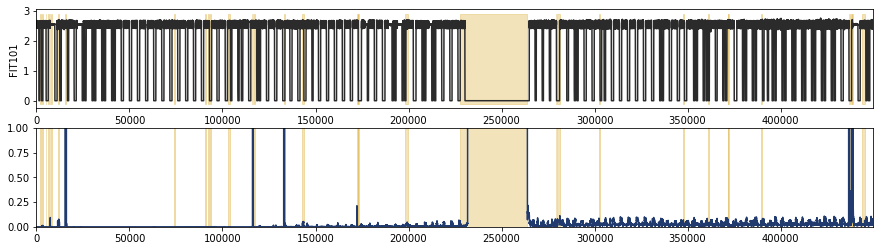

In [19]:
fig = plt_res_with_dat([score],label,test_df['FIT101'])

In [ ]:
# %debug

In [20]:
import matplotlib.pyplot as plt

In [21]:
from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(label,  score)
auc = metrics.roc_auc_score(label,  score)

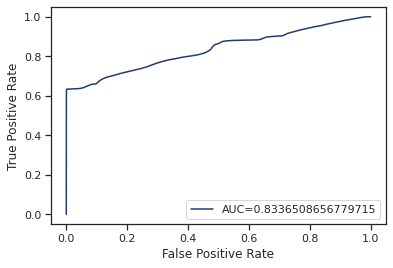

In [22]:
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

Finding error score threshold

In [23]:
!pip install ghostml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [24]:
pd.DataFrame(score).describe()

,0
count,449919.000000
mean,14.328933
std,50.672784
min,0.000000
25%,0.000056
50%,0.010142
75%,0.023678
max,200.428650


In [25]:
#normalise error score
max_score = np.max(score)
min_score = np.min(score)
norm_score = (score - min_score)/(max_score - min_score)

In [26]:
import ghostml

def calc_metrics(labels_test, test_probs, threshold = 0.5):
    scores = [1 if x>=threshold else 0 for x in test_probs]
    auc = metrics.roc_auc_score(labels_test, test_probs)
    kappa = metrics.cohen_kappa_score(labels_test,scores)
    confusion = metrics.confusion_matrix(labels_test,scores, labels=list(set(labels_test)))
    print('thresh: %.2f, kappa: %.3f, AUC test-set: %.3f'%(threshold, kappa, auc))
    print(confusion)
    print(metrics.classification_report(labels_test,scores))
    return 

In [ ]:
thresholds = np.arange(0.05,0.90,0.05)
threshold1 = ghostml.optimize_threshold_from_predictions(list(label), list(norm_score), thresholds, ThOpt_metrics = 'Kappa') 

# Print confusion matrix and classification metrics
calc_metrics(label, score, threshold = threshold1)

In [ ]:
# %debug

In [ ]:
threshold1

In [ ]:
pred_labels = np.array([1 if x>=threshold1 else 0 for x in norm_score])

In [ ]:
print(metrics.classification_report(label,pred_labels))

In [ ]:
time_pred_label = pd.DataFrame(pred_labels, index = test_df.index, columns = ['labels'])

In [67]:
time_pred_label

,labels
Timestamp,
28/12/2015 10:00:00 AM,0
28/12/2015 10:00:01 AM,0
28/12/2015 10:00:02 AM,0
28/12/2015 10:00:03 AM,0
28/12/2015 10:00:04 AM,0
...,...
2/1/2016 2:59:55 PM,0
2/1/2016 2:59:56 PM,0
2/1/2016 2:59:57 PM,0


Apply XAI

In [68]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 5.2 MB/s 


In [69]:
import shap

In [79]:
def f(X):
    return model.predict(X)

In [85]:
explainer = shap.KernelExplainer(f, test_scale[0:50],keep_index = True)

In [ ]:
shap_values50 = explainer.shap_values(test_scale, nsamples=500)

In [ ]:
%debug

In [ ]:
!pip install lime

In [108]:
import lime
import lime.lime_tabular

In [110]:
train = train_df
train['label'] = 0

In [114]:
explainer = lime.lime_tabular.LimeTabularExplainer(train, feature_names=train.columns, class_names=['label'],
                                                   verbose=True, mode='regression',
                                                   random_state = 42)

TypeError: ignored